In [19]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

X_b = np.c_[np.ones((100, 1)), X]

# 正規方程式

In [7]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.72240655],
       [3.12987398]])

# 勾配降下法

## バッチ勾配降下法
全データを使って勾配を得る。  

In [2]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1)

In [8]:
for iteration in range(n_iterations):
    gradients = 2./m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [9]:
theta

array([[3.72240655],
       [3.12987398]])

## 確率的勾配降下法<br>
一サンプルだけ使って降下、ということを繰り返す<br>

学習率を下げていかないと延々動き続けてしまう

In [10]:
n_epochs = 50
t0, t1 = 5, 50 #学習スケジュールを決定

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[3.75687053],
       [3.15128021]])

sklearnに実装されている

In [12]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) #.ravelは平坦化のメソッド

sgd_reg.intercept_, sgd_reg.coef_

(array([3.7904542]), array([3.21515006]))

## ミニバッチ勾配降下法

コードなし

# 多項式回帰

In [14]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.78769785])

In [16]:
X_poly[0]

array([2.78769785, 7.77125928])

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.3812122]), array([[1.00577334, 0.38940445]]))

# 学習曲線

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict[:m]))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="val")

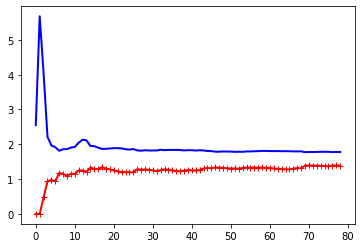

In [23]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

(0.0, 3.0)

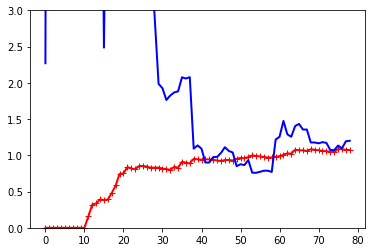

In [26]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim(0,3.0)

# 線形モデルの正則化  
## 早期打ち切り

In [29]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler()),
])

X_train, X_val, y_train, y_val = train_test_split(X, y.ravel(), test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, #warm_start=Trueは、fit()を前回訓練後の状態から続ける　tolは探索を続ける1エポックの損失の上限
                       penalty=None, learning_rate="constant", eta0=0.0005) # penaltyは正則化

minimum_val_error = float("inf")
best_epoch, best_model = None, None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [30]:
best_epoch

746

# ロジスティック回帰
## 決定境界

In [31]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [35]:
print(iris["feature_names"])
X = iris["data"][:, 3:]
y = (iris["target"]==2).astype(int)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [36]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

/Users/ryosuke/miniforge3/envs/pythontf/lib/python3.8/site-packages/matplotlib/patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


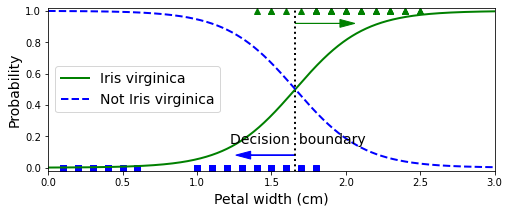

In [39]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()